In this notebook, we try to investigate the impact of east-west on the demand curve. We assume that the capacity remains constant (therefore investment costs are similar). This is not necessarily realistic, as more capacity can be installed using east-west (as described "East-west oriented photovoltaic power systems: model, benefits and  technical evaluation")

# Here we only investigate a single point (Oldenburg)

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from get_load import get_load

In [2]:
### Get load of Oldenburg

avg_demand_per_inh = 2 # MWh/a, rough estimate --> https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Umwelt/UGR/private-haushalte/Tabellen/stromverbrauch-haushalte.html
inhabitants = 168000 # inhabitants in Oldenburg
annual_demand_ol = avg_demand_per_inh*inhabitants #MWh/a
annual_demand_ol = annual_demand_ol*1e3 # kWh/a

In [3]:
df_elec_demand = get_load(2017, demand_y=annual_demand_ol)["h0"] # h0 means residential

In [4]:
df_elec_demand = df_elec_demand.to_xarray()
df_elec_demand = df_elec_demand.rename({"index":"time"})

Text(0.5, 0, 'hour of the day')

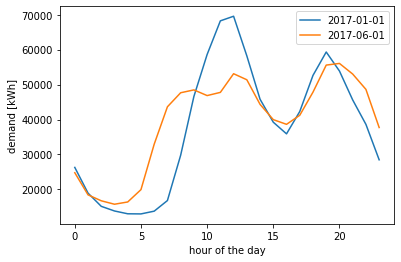

In [5]:
plt.plot(df_elec_demand.sel({"time":"2017-01-01"}).values, label="2017-01-01")
plt.plot(df_elec_demand.sel({"time":"2017-06-01"}).values, label="2017-06-01")
plt.legend()
plt.ylabel("demand [kWh]")
plt.xlabel("hour of the day")

# PV

In [6]:
from atlite.pv.solar_position import SolarPosition
from atlite.pv.irradiation import TiltedIrradiation
from atlite.pv.solar_panel_model import SolarPanelModel
from atlite.pv.orientation import get_orientation, SurfaceOrientation
from atlite.convert import pv, convert_pv, get_orientation,get_solarpanelconfig

In [7]:
#### Get roughly estimate of PV capacity in Oldenburg in 2023
capacity_ol = 0.22*inhabitants #kWp # https://www.rechnerphotovoltaik.de/photovoltaik/in/niedersachsen/oldenburg-oldb

In [8]:
capacity_ol

36960.0

In [9]:
ds = xr.open_dataset("assets/data_2017_germany.nc")
ds_oldenburg = ds.sel({"x": [8.25], "y": [53]})


In [10]:
time_shift = 0 # relevant if sarah-2 data is used
solar_position = SolarPosition(ds_oldenburg, time_shift)
solar_position.load() # this takes some time

<xarray.Dataset>
Dimensions:   (time: 8760, y: 1, x: 1)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
  * y         (y) float32 53.0
    lat       (y) float32 53.0
  * x         (x) float32 8.25
    lon       (x) float32 8.25
Data variables:
    altitude  (time, y, x) float64 -1.038 -0.9689 -0.8514 ... -0.9682 -1.038
    azimuth   (time, y, x) float64 0.2353 0.6676 1.012 ... 5.266 5.61 6.042

In [11]:
%%time 

def get_pv(orientation):
    panel = "CSi"
    panel = get_solarpanelconfig(panel)
    print(orientation)
    orientation = get_orientation(orientation)
    
    surface_orientation = SurfaceOrientation(ds_oldenburg, solar_position, orientation)
    irradiation = TiltedIrradiation(
        ds_oldenburg,
        solar_position,
        surface_orientation,
        trigon_model="simple",
        clearsky_model="simple",
    )
    ds_oldenburg_cf = SolarPanelModel(ds_oldenburg, irradiation, panel)
    #ds_oldenburg_cf = (solar_panel * capacity_ol)
    ds_oldenburg_cf = ds_oldenburg_cf.isel({"x":0,"y":0})
    return ds_oldenburg_cf


ds_east = get_pv({'slope': 50., 'azimuth': 90})
ds_south = get_pv({'slope': 40., 'azimuth': 180})
ds_west = get_pv({'slope': 50., 'azimuth': 270})

{'slope': 50.0, 'azimuth': 90}
{'slope': 40.0, 'azimuth': 180}
{'slope': 50.0, 'azimuth': 270}
CPU times: user 157 ms, sys: 8.78 ms, total: 165 ms
Wall time: 164 ms


# The duck curve

![asd](assets/duck_curve.jpg)


source: https://www.synergy.net.au/Blog/2021/10/Everything-you-need-to-know-about-the-Duck-Curve

In [12]:
# We assume to that the capacity further grows quickly to make results more obvious
capacity_expansion_factor = 2 # multiplier of todays capacity

Text(0.5, 0, 'hour of the day')

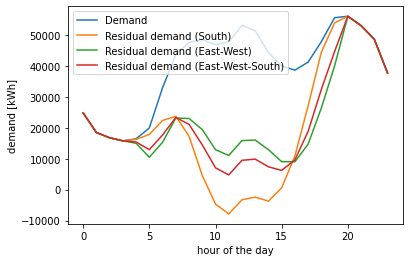

In [13]:
dt = "2017-06-01"
plt.plot((df_elec_demand).sel({"time":dt}), label="Demand")
plt.plot((df_elec_demand - ds_south*capacity_ol*capacity_expansion_factor).sel({"time":dt}), label="Residual demand (South)")
plt.plot((df_elec_demand - (ds_west*1/2 + ds_east*1/2)*capacity_ol*capacity_expansion_factor).sel({"time":dt}), label="Residual demand (East-West)")
plt.plot((df_elec_demand - (ds_west*1/3 + ds_south*1/3 + ds_east*1/3)*capacity_ol*capacity_expansion_factor).sel({"time":dt}), label="Residual demand (East-West-South)")

plt.legend()
plt.ylabel("demand [kWh]")
plt.xlabel("hour of the day")

In [14]:
ds_t = (df_elec_demand - ds_south*capacity_ol*capacity_expansion_factor)
ds_t.where(ds_t>0).sum()

<xarray.DataArray ()>
array(2.65838628e+08)
Coordinates:
    y        float32 53.0
    lat      float32 53.0
    x        float32 8.25
    lon      float32 8.25

In [15]:
ds_t = df_elec_demand - (ds_west*capacity_ol + ds_east*capacity_ol)
ds_t.where(ds_t>0).sum()

<xarray.DataArray ()>
array(2.81837198e+08)
Coordinates:
    y        float32 53.0
    lat      float32 53.0
    x        float32 8.25
    lon      float32 8.25

In [16]:
import numpy as np

In [17]:
ds_t = (df_elec_demand - ds_south*capacity_ol*capacity_expansion_factor)
print(ds_t.where(ds_t>0).max().values)
print(ds_t.where(ds_t).sum().values)

ds_all_south = ds_t.copy()
ds_all_south.to_dataframe("name").describe()

70701.38338546651
264761101.32086074


,y,lat,x,lon,name
count,8760.0,8760.0,8760.00,8760.00,8760.000000
mean,53.0,53.0,8.25,8.25,30223.870014
std,0.0,0.0,0.00,0.00,16304.594982
min,53.0,53.0,8.25,8.25,-20514.790790
25%,53.0,53.0,8.25,8.25,16544.769756
50%,53.0,53.0,8.25,8.25,29068.591808
75%,53.0,53.0,8.25,8.25,43295.007616
max,53.0,53.0,8.25,8.25,70701.383385


In [18]:
ds_t = df_elec_demand - (ds_west*1/2 + ds_east*1/2)*capacity_ol*capacity_expansion_factor
print(ds_t.where(ds_t>0).max().values)
print(ds_t.where(ds_t>0).sum().values)
ds_east_west = ds_t.copy()
ds_east_west.to_dataframe("name").describe()


70701.38338546651
281837198.2725042


,y,lat,x,lon,name
count,8760.0,8760.0,8760.00,8760.00,8760.000000
mean,53.0,53.0,8.25,8.25,32173.196085
std,0.0,0.0,0.00,0.00,14615.368694
min,53.0,53.0,8.25,8.25,-0.570464
25%,53.0,53.0,8.25,8.25,18452.616909
50%,53.0,53.0,8.25,8.25,30945.123341
75%,53.0,53.0,8.25,8.25,43295.007616
max,53.0,53.0,8.25,8.25,70701.383385


In [19]:
ds_t = df_elec_demand - (ds_west*1/3 + ds_south*1/3 + ds_east*1/3)*capacity_ol*capacity_expansion_factor
print(ds_t.where(ds_t>0).max().values)
print(ds_t.where(ds_t>0).sum().values)
ds_east_west_south = ds_t.copy()
ds_east_west_south.to_dataframe("name").describe()

70701.38338546651
276169556.1920192


,y,lat,x,lon,name
count,8760.0,8760.0,8760.00,8760.00,8760.000000
mean,53.0,53.0,8.25,8.25,31523.420728
std,0.0,0.0,0.00,0.00,14941.827915
min,53.0,53.0,8.25,8.25,-4200.445271
25%,53.0,53.0,8.25,8.25,17712.358754
50%,53.0,53.0,8.25,8.25,30247.934805
75%,53.0,53.0,8.25,8.25,43295.007616
max,53.0,53.0,8.25,8.25,70701.383385


Text(0.5, 1.0, 'hourly mean in the entire year')

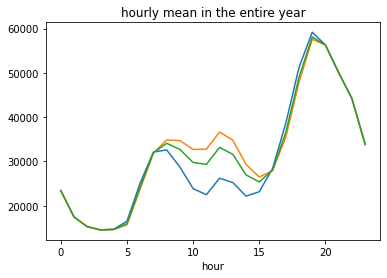

In [20]:
ds_all_south.groupby("time.hour").mean().plot()
ds_east_west.groupby("time.hour").mean().plot()
ds_east_west_south.groupby("time.hour").mean().plot()
plt.title("hourly mean in the entire year")

Text(0, 0.5, 'Values')

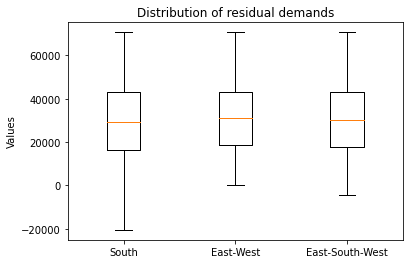

In [21]:
plt.boxplot([ds_all_south, ds_east_west, ds_east_west_south])

# Adding titles and labels
plt.title('Distribution of residual demands')
plt.xticks([1, 2, 3], ['South', 'East-West', 'East-South-West'])
plt.ylabel('Values')
